### 1. Import thư viện 

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline  # Import Pipeline
from sklearn.metrics import classification_report, accuracy_score
import joblib
import os
import re

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

### 2. Tiền xử lý dữ liệu 

In [16]:
# Tải dữ liệu
df = pd.read_csv('data/spam_ham_dataset.csv')

def clean_text(text):
    # Loại bỏ Subject: prefix
    text = re.sub(r'^Subject:\s*', '', text)
    # Loại bỏ email addresses
    text = re.sub(r'\S+@\S+', '', text)
    # Loại bỏ URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    # Loại bỏ ký tự đặc biệt và số
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Loại bỏ khoảng trắng thừa
    text = ' '.join(text.split())
    return text.lower().strip()

# Áp dụng cleaning
df['cleaned_text'] = df['text'].apply(clean_text)

# Loại bỏ text rỗng
df = df[df['cleaned_text'].str.len() > 0]
# Chọn các cột cần thiết
data = df[['cleaned_text', 'label_num' ]].copy()

print("Đã tải và làm sạch dữ liệu xong.")
print(f"Tổng số mẫu: {len(df)}")

Đã tải và làm sạch dữ liệu xong.
Tổng số mẫu: 5153


In [17]:
print("Dữ liệu sau khi làm sạch:")
data.head()

Dữ liệu sau khi làm sạch:


,cleaned_text,label_num
0,enron methanol meter this is a follow up to th...,0
1,hpl nom for january see attached file hplnol x...,0
2,neon retreat ho ho ho we re around to that mos...,0
3,photoshop windows office cheap main trending a...,1
4,re indian springs this deal is to book the tec...,0


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5153 entries, 0 to 5170
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    5153 non-null   int64 
 1   label         5153 non-null   object
 2   text          5153 non-null   object
 3   label_num     5153 non-null   int64 
 4   cleaned_text  5153 non-null   object
dtypes: int64(2), object(3)
memory usage: 241.5+ KB


In [19]:
df['label'].value_counts()


label
ham     3672
spam    1481
Name: count, dtype: int64

### 3. Chia dữ liệu và Vector hóa (Bag of Words)


In [20]:
# Bước 1: Chia dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Bước 2: Khởi tạo CountVectorizer
# max_features=5000: Chỉ xem xét 5000 từ phổ biến nhất để tránh tốn bộ nhớ.
vectorizer = CountVectorizer(max_features=5000, stop_words='english')

# Bước 3: Học từ vựng và biến đổi tập huấn luyện (fit_transform)
print("Bắt đầu biến đổi văn bản thành vector...")
X_train_vectors = vectorizer.fit_transform(X_train)

# Bước 4: Chỉ biến đổi tập kiểm tra với từ vựng đã học (transform)
X_test_vectors = vectorizer.transform(X_test)

print("Hoàn thành!")
print("Kích thước ma trận vector của tập huấn luyện:", X_train_vectors.shape)
print("Kích thước ma trận vector của tập kiểm tra:", X_test_vectors.shape)

Bắt đầu biến đổi văn bản thành vector...


Hoàn thành!
Kích thước ma trận vector của tập huấn luyện: (4122, 5000)
Kích thước ma trận vector của tập kiểm tra: (1031, 5000)


### 4. Huấn luyện mô hình 

In [22]:
# Bước 1: Định nghĩa một Pipeline
# Pipeline này sẽ tự động thực hiện việc vector hóa rồi mới huấn luyện mô hình.
pipe = Pipeline([
    ('vectorizer', CountVectorizer(stop_words='english')),
    ('classifier', LogisticRegression(class_weight='balanced', max_iter=2000, random_state=42))
])

# Bước 2: Định nghĩa lưới tham số (parameter grid) để tìm kiếm
# Ta có thể tinh chỉnh tham số cho cả 'vectorizer' và 'classifier'.
# Tên tham số phải theo cấu trúc: a__b (với a là tên bước, b là tên tham số)
param_grid = {
    'vectorizer__max_features': [3000, 5000, 7000],  # Số lượng từ tốt nhất để giữ lại
    'vectorizer__ngram_range': [(1, 1), (1, 2)],  # Chỉ dùng từ đơn, hay cả từ đơn và từ đôi
    'classifier__C': [0.1, 1, 10],  # Tham số điều chuẩn (regularization) của Logistic Regression
}

# Bước 3: Khởi tạo GridSearchCV
# cv=5: Sử dụng 5-fold cross-validation.
grid_search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring='f1_weighted', # Đánh giá dựa trên F1-score vì dữ liệu có thể mất cân bằng
    cv=5,
    verbose=1,
    n_jobs=-1  # Sử dụng tất cả các nhân CPU có sẵn
)

# Bước 4: Chạy Grid Search trên tập huấn luyện
# Nó sẽ tự động thử tất cả các kết hợp trong param_grid.
print("Bắt đầu tìm kiếm tham số tốt nhất với GridSearchCV...")
grid_search.fit(X_train, y_train)

# In ra kết quả
print(f"\\nCác tham số tốt nhất tìm được: {grid_search.best_params_}")
print(f"Điểm F1-score tốt nhất trên tập validation: {grid_search.best_score_:.4f}")

Bắt đầu tìm kiếm tham số tốt nhất với GridSearchCV...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
\nCác tham số tốt nhất tìm được: {'classifier__C': 10, 'vectorizer__max_features': 5000, 'vectorizer__ngram_range': (1, 1)}
Điểm F1-score tốt nhất trên tập validation: 0.9750


### 5. Đánh giá mô hình 


Độ chính xác (Accuracy) trên tập test: 0.9796

Báo cáo phân loại (Classification Report):
              precision    recall  f1-score   support

         Ham       1.00      0.98      0.99       735
        Spam       0.94      0.99      0.97       296

    accuracy                           0.98      1031
   macro avg       0.97      0.98      0.98      1031
weighted avg       0.98      0.98      0.98      1031



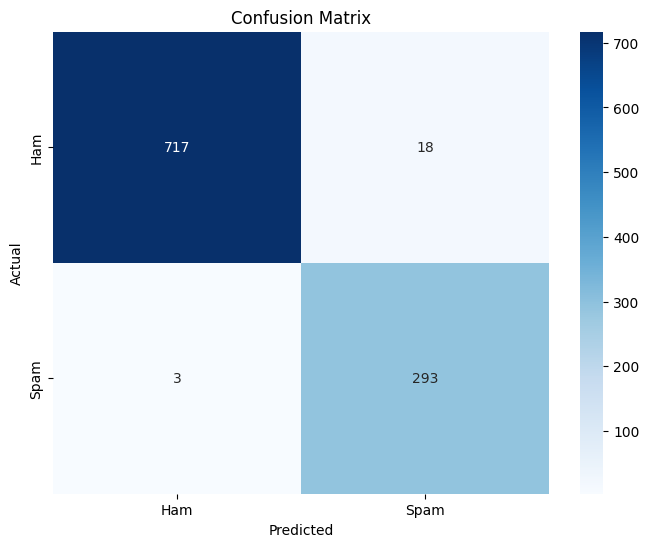

In [25]:
# Lấy ra pipeline tốt nhất
best_model = grid_search.best_estimator_

# Dự đoán trên tập test (dữ liệu mà mô hình chưa từng thấy)
y_pred = best_model.predict(X_test)

# In báo cáo kết quả
print(f"\nĐộ chính xác (Accuracy) trên tập test: {accuracy_score(y_test, y_pred):.4f}")
print("\nBáo cáo phân loại (Classification Report):")
print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### 6. Lưu và sử dụng Pipeline

In [26]:

# Đường dẫn lưu file
PIPELINE_PATH = 'checkpoints/logistic_regression_best.pkl'

# Lưu pipeline
joblib.dump(best_model, PIPELINE_PATH)

print(f"Đã lưu pipeline tốt nhất tại: '{PIPELINE_PATH}'")

Đã lưu pipeline tốt nhất tại: 'checkpoints/logistic_regression_best.pkl'


In [30]:
# ----- Thử nghiệm Pipeline đã lưu -----

# Tải lại pipeline
loaded_pipeline = joblib.load(PIPELINE_PATH)

print("\nĐã tải lại pipeline và sẵn sàng để dự đoán.")

# Tin nhắn mới cần dự đoán
new_messages = [
    # Spam emails
    "CONGRATULATIONS! You've won $10,000! Click here to claim your prize NOW!",
    "Urgent: Your PayPal account has been limited. Verify immediately to avoid suspension",
    "Make money from home! Earn $5000 per week working part-time!",
    "FREE iPhone 15! Limited time offer! Click here before it expires!",
    "Nigerian Prince needs your help. Guaranteed $1,000,000 return!",
    
    # Ham emails
    "Team meeting scheduled for tomorrow at 3 PM in the conference room",
    "Your order #12345 has been shipped and will arrive in 2-3 business days",
    "Monthly project status report - please review before Friday",
    "Reminder: Your dentist appointment is scheduled for next Monday",
    "Happy birthday! Hope you have a wonderful celebration today, can i go to your party tonight?"
]

# Pipeline sẽ tự động làm sạch, vector hóa và dự đoán
predictions = loaded_pipeline.predict(new_messages)
labels = ["Spam" if p == 1 else "Ham" for p in predictions]

# In kết quả
for i, msg in enumerate(new_messages):
    print(f"\nTin nhắn: '{msg}'")
    print(f"Dự đoán: {labels[i]}")


Đã tải lại pipeline và sẵn sàng để dự đoán.

Tin nhắn: 'CONGRATULATIONS! You've won $10,000! Click here to claim your prize NOW!'
Dự đoán: Spam

Tin nhắn: 'Urgent: Your PayPal account has been limited. Verify immediately to avoid suspension'
Dự đoán: Spam

Tin nhắn: 'Make money from home! Earn $5000 per week working part-time!'
Dự đoán: Spam

Tin nhắn: 'FREE iPhone 15! Limited time offer! Click here before it expires!'
Dự đoán: Spam

Tin nhắn: 'Nigerian Prince needs your help. Guaranteed $1,000,000 return!'
Dự đoán: Spam

Tin nhắn: 'Team meeting scheduled for tomorrow at 3 PM in the conference room'
Dự đoán: Ham

Tin nhắn: 'Your order #12345 has been shipped and will arrive in 2-3 business days'
Dự đoán: Spam

Tin nhắn: 'Monthly project status report - please review before Friday'
Dự đoán: Spam

Tin nhắn: 'Reminder: Your dentist appointment is scheduled for next Monday'
Dự đoán: Spam

Tin nhắn: 'Happy birthday! Hope you have a wonderful celebration today, can i go to your party tonigh